# **성능관리**

## **1.환경준비**

### **(1) 라이브러리 로딩**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.datasets import mnist

* 함수 만들기

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### **(2) 데이터로딩**

* 데이터 로딩
    * 과적합을 위한 예제 데이터입니다.
    * target
    * feature : 0 ~ 299

In [3]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/overfit_sample.csv"
data = pd.read_csv(path)
data.head()

,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,-0.624,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,1,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,-0.118,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,-0.656,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


In [4]:
data.shape

(250, 301)

## **2. Early Stopping**

### **(1) 데이터 준비**

In [5]:
# 데이터분할 : x, y
target = 'target'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

# 데이터분할 : train, validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

In [6]:
# 스케일링
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### **(2) 모델링**

In [7]:
# input_shape : feature 수 도출
nfeatures = x_train.shape[1]

# 메모리 정리
clear_session()

# Sequential 타입
model1 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation= 'relu'),
                      Dense(64, activation= 'relu'),
                      Dense(32, activation= 'relu'),
                      Dense(1, activation= 'sigmoid')] )

# 컴파일
model1.compile(optimizer= Adam(learning_rate = 0.001), loss='binary_crossentropy')

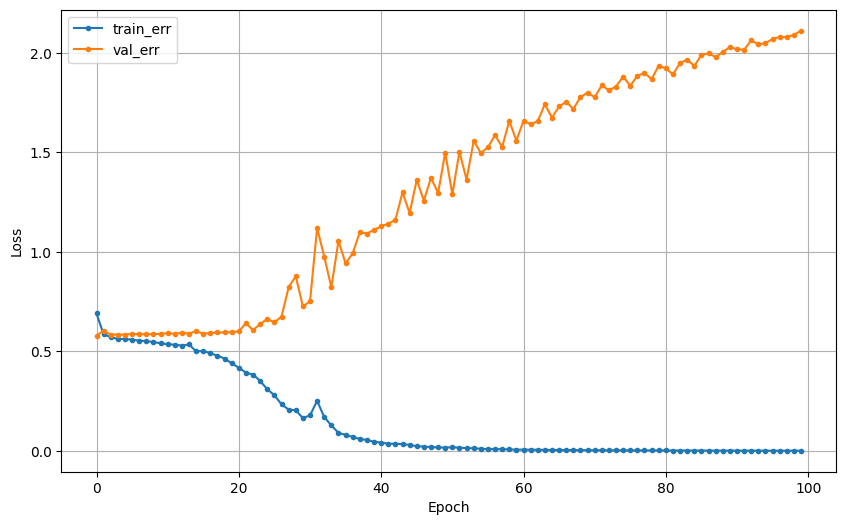

In [8]:
# 학습
hist = model1.fit(x_train, y_train, epochs = 100, validation_split=0.2, verbose = 0).history

# 학습결과 그래프
dl_history_plot(hist)

### **(3) 미리 멈춤!(Early Stopping)**

#### 1) 함수 불러오기

In [9]:
from keras.callbacks import EarlyStopping

#### 2) 모델링 with early stopping

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.7645 - val_loss: 0.6190
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5525 - val_loss: 0.5835
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5565 - val_loss: 0.5832
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6038 - val_loss: 0.5810
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5522 - val_loss: 0.5974
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5288 - val_loss: 0.5829
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5187 - val_loss: 0.5840
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5182 - val_loss: 0.5815
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5425 - val_loss: 0.5791
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5876 - val_loss: 0.5831
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5005 - val_loss: 0.5838
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5012 - val_loss: 0.585

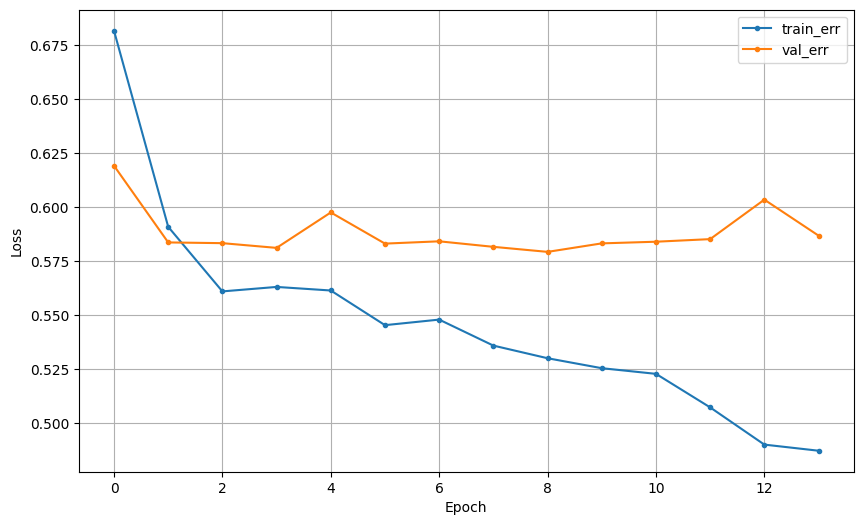

In [32]:
# 모델 선언
clear_session()

model2 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation= 'relu'),
                      Dense(64, activation= 'relu'),
                      Dense(32, activation= 'relu'),
                      Dense(1, activation= 'sigmoid')] )
model2.compile(optimizer= Adam(learning_rate = 0.001), loss='binary_crossentropy')

# EarlyStopping 설정 ------------
min_de = 0.001
pat = 5

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)
# --------------------------------

# 학습
hist = model2.fit(x_train, y_train, epochs = 100, validation_split=0.2,
                  callbacks = [es]).history
dl_history_plot(hist)

## 3.Dropout

In [11]:
from keras.layers import Dropout

### **(1) 적용 전**

In [12]:
# input_shape : feature 수 도출
nfeatures = x_train.shape[1]

# 메모리 정리
clear_session()

# Sequential 타입
model1 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation= 'relu'),
                      Dense(64, activation= 'relu'),
                      Dense(32, activation= 'relu'),
                      Dense(1, activation= 'sigmoid')] )

# 컴파일
model1.compile(optimizer= Adam(learning_rate = 0.001), loss='binary_crossentropy')

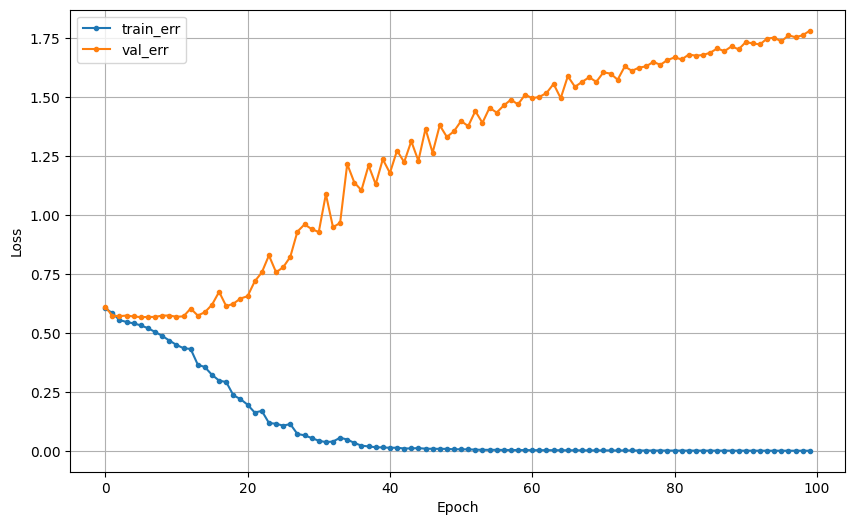

In [13]:
# 학습
hist = model1.fit(x_train, y_train, epochs = 100, validation_split=0.2, verbose = 0).history

# 학습결과 그래프
dl_history_plot(hist)

### **(2) 적용 후**

In [14]:
# 메모리 정리
clear_session()

# Sequential 타입
model3 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation= 'relu'),
                      Dropout(0.4),
                      Dense(64, activation= 'relu'),
                      Dropout(0.4),
                      Dense(32, activation= 'relu'),
                      Dropout(0.4),
                      Dense(1, activation= 'sigmoid')] )

# 컴파일
model3.compile(optimizer= Adam(learning_rate = 0.001), loss='binary_crossentropy')

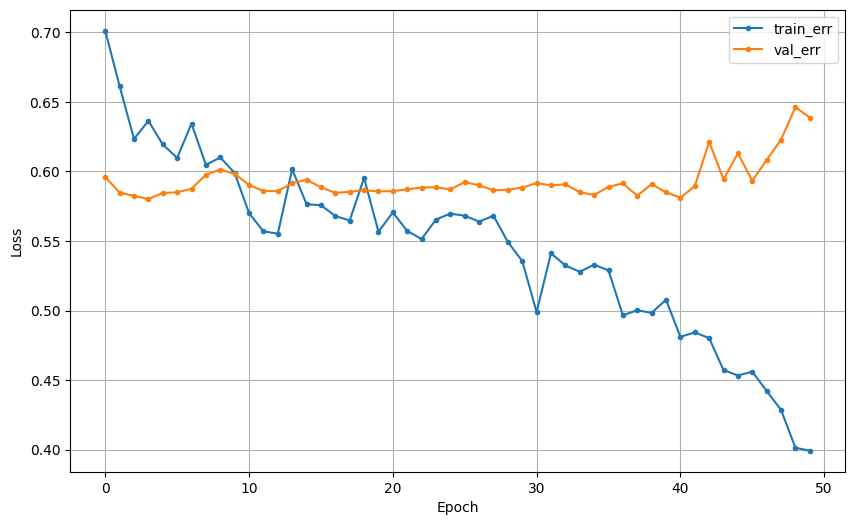

In [15]:
# 학습
hist = model3.fit(x_train, y_train, epochs = 50, validation_split=0.2, verbose = 0).history

# 학습결과 그래프
dl_history_plot(hist)

## 4.모델 저장하기

### (1) 모델 저장하기

* model.save(‘파일이름.keras’)
    * 딥러닝 모델의 메소드로 .save가 제공됩니다.
    * 파일이름.keras 파일이 저장됩니다.

In [37]:
model1.save('/content/drive/MyDrive/딥러닝/hanky.keras')

* 저장된 파일은 왼쪽 '파일'탭에서 확인 가능
* 파일을 다운로드 받을 수 있다.

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 모델 로딩하기

* load_model 함수는 별도로 불러와야 합니다.
* 경로를 맞춰주고 h5 파일을 읽어오면 그대로 사용 가능합니다.

In [38]:
from keras.models import load_model
model2 = load_model('hanky.keras')

* 불러온 모델 사용하기

In [18]:
pred2 = model2.predict(x_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


In [19]:
pred2

array([[1.0410765e-04],
       [3.3273067e-02],
       [8.6763799e-01],
       [3.5714933e-03],
       [5.0438572e-05],
       [9.3281156e-01],
       [2.3236212e-03],
       [1.6187315e-04],
       [1.4090874e-02],
       [8.9282167e-01],
       [1.7679129e-02],
       [6.9607835e-04],
       [9.3999406e-05],
       [2.8962454e-02],
       [4.7728480e-04],
       [9.9230157e-03],
       [8.0274121e-04],
       [1.0743436e-03],
       [2.5112284e-04],
       [9.8508626e-06],
       [2.8202441e-01],
       [7.2912425e-01],
       [8.8318601e-02],
       [9.3386903e-02],
       [6.6450752e-02],
       [4.5535678e-01],
       [6.9835663e-02],
       [7.0263550e-02],
       [2.5890561e-04],
       [1.6011908e-03],
       [8.9461243e-01],
       [3.4215671e-04],
       [1.2684803e-03],
       [6.0159600e-01],
       [1.3238666e-04],
       [1.2341659e-03],
       [2.8019869e-05],
       [2.4914360e-03],
       [1.7604631e-03],
       [5.1306069e-02],
       [1.6256256e-02],
       [4.866820

In [20]:
pred2_1 = np.where(pred2> .5, 1, 0)

In [21]:
print(accuracy_score(y_val,pred2_1))
print('-'*60)
print(confusion_matrix(y_val, pred2_1))
print('-'*60)
print(classification_report(y_val, pred2_1))

0.64
------------------------------------------------------------
[[30  5]
 [13  2]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.86      0.77        35
           1       0.29      0.13      0.18        15

    accuracy                           0.64        50
   macro avg       0.49      0.50      0.48        50
weighted avg       0.57      0.64      0.59        50



### (3) 중간 체크포인트에 모델 저장하기

* 폴더 정리 : 위에서 저장한 파일들 제거하기

In [22]:
import os

def delete_h5_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".keras"):
            file_path = os.path.join(directory, filename)
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")

# 삭제할 디렉토리 지정
directory_to_delete_from = "/content/"

# 확장자가 .h5인 파일 삭제
delete_h5_files(directory_to_delete_from)


Deleted: /content/hanky.keras


#### 1) 체크포인트 함수 불러오기

In [23]:
from keras.callbacks import ModelCheckpoint

#### 2) 모델링 체크포인트 저장

* 모델 선언

In [24]:
# input_shape : feature 수 도출
nfeatures = x_train.shape[1]

# 메모리 정리
clear_session()

# Sequential 타입
model1 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(64, activation= 'relu'),
                      Dense(32, activation= 'relu'),
                      Dense(16, activation= 'relu'),
                      Dense(1, activation= 'sigmoid')] )

# 컴파일
model1.compile(optimizer= Adam(learning_rate = 0.0001), loss='binary_crossentropy')

* 체크포인트 저장
    * 아래 코드에서 ModelCheckpoint 콜백은 검증 데이터의 정확도(val_accuracy)를 기준으로 모델 저장
    * 모델의 성능이 이전에 저장된 모델보다 향상될 때만 저장되도록 save_best_only=True로 설정
    * 또한, verbose=1로 설정하면 모델이 저장될 때마다 콘솔에 메시지가 표시됨.

In [25]:
cp_path = '/content/{epoch:03d}.keras'  # Keras 2.11 이상 버전에서 모델 확장자 .keras
mcp = ModelCheckpoint(cp_path, monitor='val_loss', verbose = 1, save_best_only=True)

# 학습
hist = model1.fit(x_train, y_train, epochs = 50, validation_split=.2, callbacks=[mcp]).history

Epoch 1/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 0.7666
Epoch 1: val_loss improved from inf to 0.71981, saving model to /content/001.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - loss: 0.7586 - val_loss: 0.7198
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.7109
Epoch 2: val_loss improved from 0.71981 to 0.66620, saving model to /content/002.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.6998 - val_loss: 0.6662
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6788
Epoch 3: val_loss improved from 0.66620 to 0.63011, saving model to /content/003.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6568 - val_loss: 0.6301
Epoch 4/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.6299
Epoch 4: val_loss improved from 0.63011 to 0.60951, saving model to /content/004.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6285 - val_loss: 0.6095
Epoch 5/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.6016
Epoch 5: val_loss improved from 0.60951 to 0.59766

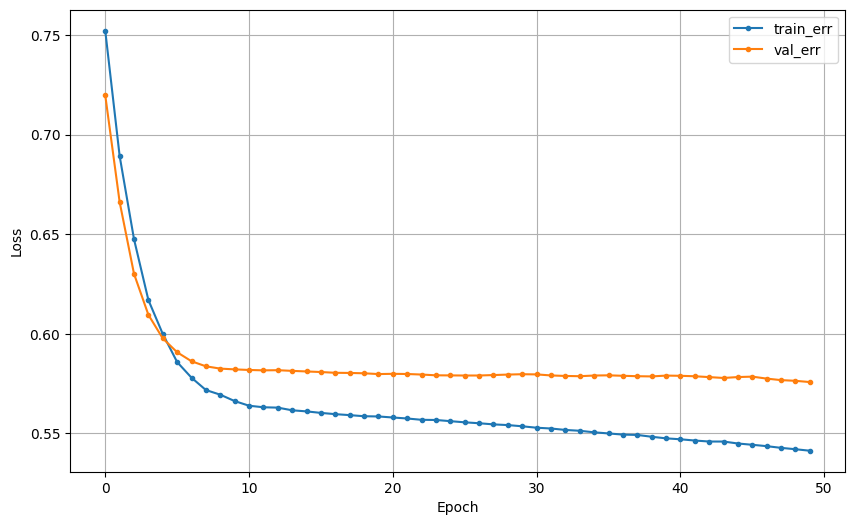

In [26]:
# 학습결과 그래프
dl_history_plot(hist)

## **5.[참조]가중치 규제(Regularization)**

In [27]:
# 규제를 위해 필요한 함수 불러오기
from keras.regularizers import l1, l2

### **(1) L1 규제**

In [28]:
# 메모리 정리
clear_session()

# Sequential 타입
model4 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation= 'relu',
                            kernel_regularizer = l1(0.01)),
                      Dense(64, activation= 'relu',
                            kernel_regularizer = l1(0.01)),
                      Dense(32, activation= 'relu',
                            kernel_regularizer = l1(0.01)),
                      Dense(1, activation= 'sigmoid')] )

# 컴파일
model4.compile(optimizer= Adam(learning_rate = 0.001), loss='binary_crossentropy')

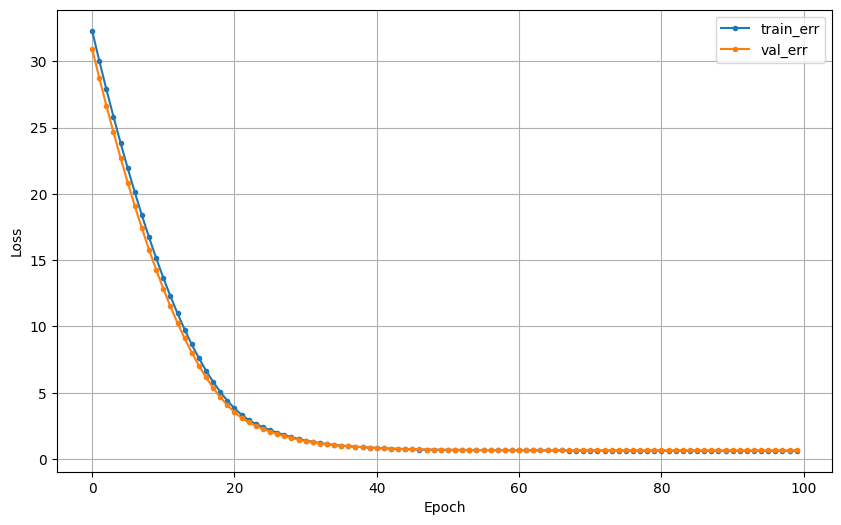

In [29]:
# 학습
hist = model4.fit(x_train, y_train, epochs = 100, validation_split=0.2, verbose = 0).history

# 학습결과 그래프
dl_history_plot(hist)

### **(2) L2 규제**

In [30]:
# 메모리 정리
clear_session()

# Sequential 타입
model5 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation= 'relu',
                            kernel_regularizer = l2(0.05)),
                      Dense(64, activation= 'relu',
                            kernel_regularizer = l2(0.05)),
                      Dense(32, activation= 'relu',
                            kernel_regularizer = l2(0.05)),
                      Dense(1, activation= 'sigmoid')] )

# 컴파일
model5.compile(optimizer= Adam(learning_rate = 0.001), loss='binary_crossentropy')

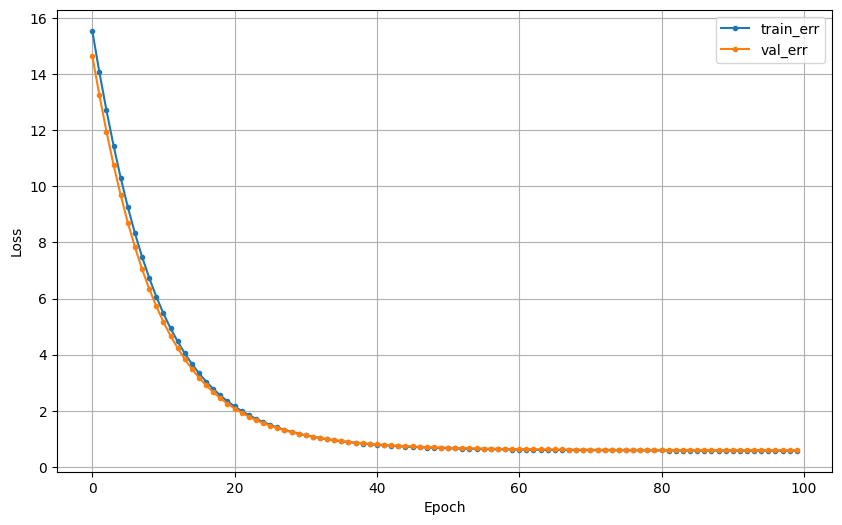

In [31]:
# 학습
hist = model5.fit(x_train, y_train, epochs = 100, validation_split=0.2, verbose = 0).history

# 학습결과 그래프
dl_history_plot(hist)